<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE1_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : VAE1
Run time             : Monday 01 March 2021, 20:35:10
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE1_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE1_done/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
Uncomment the right lines according to what you want.

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
latent_dim           : 2
r_loss_factor        : 0.994
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
### 3.1 - Get it

In [4]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)



Train shape after rescale :  (70000, 28, 28, 1)


### 3.2 - Have a look

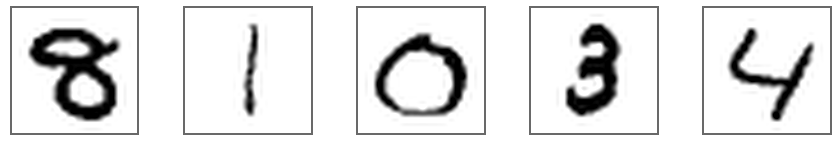

In [5]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [10]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:09:48 - loss: 0.6887 - r_loss: 0.6929 - kl_loss: 2.0104e-04

  12/1094 [..............................] - ETA: 5s - loss: 0.6350 - r_loss: 0.6287 - kl_loss: 1.6816         

  24/1094 [..............................] - ETA: 4s - loss: 0.5459 - r_loss: 0.5435 - kl_loss: 0.9455

  36/1094 [..............................] - ETA: 4s - loss: 0.4841 - r_loss: 0.4832 - kl_loss: 0.6309

  48/1094 [>.............................] - ETA: 4s - loss: 0.4388 - r_loss: 0.4386 - kl_loss: 0.4734

  60/1094 [>.............................] - ETA: 4s - loss: 0.4061 - r_loss: 0.4063 - kl_loss: 0.3788

  72/1094 [>.............................] - ETA: 4s - loss: 0.3839 - r_loss: 0.3843 - kl_loss: 0.3158

  84/1094 [=>............................] - ETA: 4s - loss: 0.3671 - r_loss: 0.3677 - kl_loss: 0.2708

  96/1094 [=>............................] - ETA: 4s - loss: 0.3544 - r_loss: 0.3551 - kl_loss: 0.2370

 108/1094 [=>............................] - ETA: 4s - loss: 0.3445 - r_loss: 0.3453 - kl_loss: 0.2107

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3365 - r_loss: 0.3374 - kl_loss: 0.1897

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3301 - r_loss: 0.3311 - kl_loss: 0.1725

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3244 - r_loss: 0.3254 - kl_loss: 0.1582

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3199 - r_loss: 0.3209 - kl_loss: 0.1461

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3160 - r_loss: 0.3171 - kl_loss: 0.1358

 180/1094 [===>..........................] - ETA: 4s - loss: 0.3123 - r_loss: 0.3134 - kl_loss: 0.1276

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3095 - r_loss: 0.3107 - kl_loss: 0.1222

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3070 - r_loss: 0.3081 - kl_loss: 0.1266

 216/1094 [====>.........................] - ETA: 3s - loss: 0.3044 - r_loss: 0.3054 - kl_loss: 0.1377

 228/1094 [=====>........................] - ETA: 3s - loss: 0.3018 - r_loss: 0.3026 - kl_loss: 0.1633

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2993 - r_loss: 0.2999 - kl_loss: 0.1895

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2969 - r_loss: 0.2974 - kl_loss: 0.2168

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2946 - r_loss: 0.2949 - kl_loss: 0.2414

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2925 - r_loss: 0.2926 - kl_loss: 0.2677

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2906 - r_loss: 0.2906 - kl_loss: 0.2903

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2889 - r_loss: 0.2887 - kl_loss: 0.3125

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2872 - r_loss: 0.2869 - kl_loss: 0.3315

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2856 - r_loss: 0.2852 - kl_loss: 0.3501

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2842 - r_loss: 0.2837 - kl_loss: 0.3687

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2828 - r_loss: 0.2822 - kl_loss: 0.3873

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2814 - r_loss: 0.2806 - kl_loss: 0.4073

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2800 - r_loss: 0.2791 - kl_loss: 0.4332

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2786 - r_loss: 0.2775 - kl_loss: 0.4642

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2772 - r_loss: 0.2759 - kl_loss: 0.4945

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2758 - r_loss: 0.2743 - kl_loss: 0.5280

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2745 - r_loss: 0.2728 - kl_loss: 0.5576

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2732 - r_loss: 0.2713 - kl_loss: 0.5863

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2720 - r_loss: 0.2699 - kl_loss: 0.6152

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2708 - r_loss: 0.2685 - kl_loss: 0.6430

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2696 - r_loss: 0.2672 - kl_loss: 0.6708

 480/1094 [============>.................] - ETA: 2s - loss: 0.2685 - r_loss: 0.2659 - kl_loss: 0.6983

 492/1094 [============>.................] - ETA: 2s - loss: 0.2673 - r_loss: 0.2646 - kl_loss: 0.7230

 504/1094 [============>.................] - ETA: 2s - loss: 0.2663 - r_loss: 0.2634 - kl_loss: 0.7487

 516/1094 [=============>................] - ETA: 2s - loss: 0.2653 - r_loss: 0.2622 - kl_loss: 0.7728

 528/1094 [=============>................] - ETA: 2s - loss: 0.2643 - r_loss: 0.2611 - kl_loss: 0.7966

 540/1094 [=============>................] - ETA: 2s - loss: 0.2634 - r_loss: 0.2600 - kl_loss: 0.8179

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2625 - r_loss: 0.2590 - kl_loss: 0.8383

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2580 - kl_loss: 0.8599

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2607 - r_loss: 0.2570 - kl_loss: 0.8795

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2599 - r_loss: 0.2561 - kl_loss: 0.8984

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2591 - r_loss: 0.2551 - kl_loss: 0.9175

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2583 - r_loss: 0.2543 - kl_loss: 0.9349

 624/1094 [================>.............] - ETA: 2s - loss: 0.2575 - r_loss: 0.2533 - kl_loss: 0.9526

 636/1094 [================>.............] - ETA: 2s - loss: 0.2568 - r_loss: 0.2525 - kl_loss: 0.9703

 648/1094 [================>.............] - ETA: 1s - loss: 0.2561 - r_loss: 0.2516 - kl_loss: 0.9865

 660/1094 [=================>............] - ETA: 1s - loss: 0.2553 - r_loss: 0.2508 - kl_loss: 1.0021

 672/1094 [=================>............] - ETA: 1s - loss: 0.2547 - r_loss: 0.2501 - kl_loss: 1.0168

 684/1094 [=================>............] - ETA: 1s - loss: 0.2540 - r_loss: 0.2493 - kl_loss: 1.0322

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2534 - r_loss: 0.2486 - kl_loss: 1.0464

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2528 - r_loss: 0.2479 - kl_loss: 1.0610

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2522 - r_loss: 0.2473 - kl_loss: 1.0748

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2517 - r_loss: 0.2467 - kl_loss: 1.0888

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2512 - r_loss: 0.2460 - kl_loss: 1.1024

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2507 - r_loss: 0.2455 - kl_loss: 1.1156

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2501 - r_loss: 0.2448 - kl_loss: 1.1293

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2496 - r_loss: 0.2442 - kl_loss: 1.1419

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2491 - r_loss: 0.2436 - kl_loss: 1.1547

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2486 - r_loss: 0.2430 - kl_loss: 1.1663

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2481 - r_loss: 0.2425 - kl_loss: 1.1777

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2477 - r_loss: 0.2420 - kl_loss: 1.1895

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2472 - r_loss: 0.2415 - kl_loss: 1.2013

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2468 - r_loss: 0.2410 - kl_loss: 1.2124

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2464 - r_loss: 0.2405 - kl_loss: 1.2231

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2459 - r_loss: 0.2399 - kl_loss: 1.2344

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2455 - r_loss: 0.2394 - kl_loss: 1.2438

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2451 - r_loss: 0.2390 - kl_loss: 1.2537

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2447 - r_loss: 0.2386 - kl_loss: 1.2625

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2444 - r_loss: 0.2382 - kl_loss: 1.2725

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2440 - r_loss: 0.2377 - kl_loss: 1.2823

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2436 - r_loss: 0.2373 - kl_loss: 1.2915

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2433 - r_loss: 0.2369 - kl_loss: 1.3006

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2429 - r_loss: 0.2364 - kl_loss: 1.3098

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2426 - r_loss: 0.2361 - kl_loss: 1.3187

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2423 - r_loss: 0.2357 - kl_loss: 1.3265

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2419 - r_loss: 0.2353 - kl_loss: 1.3360

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2416 - r_loss: 0.2349 - kl_loss: 1.3440

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2413 - r_loss: 0.2346 - kl_loss: 1.3516

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2409 - r_loss: 0.2342 - kl_loss: 1.3596

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2406 - r_loss: 0.2338 - kl_loss: 1.3672

1068/1094 [============================>.] - ETA: 0s - loss: 0.2403 - r_loss: 0.2334 - kl_loss: 1.3741

1080/1094 [============================>.] - ETA: 0s - loss: 0.2400 - r_loss: 0.2331 - kl_loss: 1.3818

1092/1094 [============================>.] - ETA: 0s - loss: 0.2397 - r_loss: 0.2328 - kl_loss: 1.3895

1094/1094 [==============================] - ETA: 0s - loss: 0.2397 - r_loss: 0.2327 - kl_loss: 1.3906

1094/1094 [==============================] - 9s 4ms/step - loss: 0.2396 - r_loss: 0.2327 - kl_loss: 1.3912


Saved - loss=0.205477
Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2087 - r_loss: 0.1979 - kl_loss: 1.9824

  13/1094 [..............................] - ETA: 4s - loss: 0.2140 - r_loss: 0.2031 - kl_loss: 2.0208

  25/1094 [..............................] - ETA: 4s - loss: 0.2142 - r_loss: 0.2030 - kl_loss: 2.0736

  37/1094 [>.............................] - ETA: 4s - loss: 0.2136 - r_loss: 0.2024 - kl_loss: 2.0668

  49/1094 [>.............................] - ETA: 4s - loss: 0.2116 - r_loss: 0.2003 - kl_loss: 2.0878

  61/1094 [>.............................] - ETA: 4s - loss: 0.2114 - r_loss: 0.2001 - kl_loss: 2.0844

  73/1094 [=>............................] - ETA: 4s - loss: 0.2116 - r_loss: 0.2002 - kl_loss: 2.0921

  85/1094 [=>............................] - ETA: 4s - loss: 0.2110 - r_loss: 0.1996 - kl_loss: 2.0940

  97/1094 [=>............................] - ETA: 4s - loss: 0.2108 - r_loss: 0.1994 - kl_loss: 2.0974

 109/1094 [=>............................] - ETA: 4s - loss: 0.2108 - r_loss: 0.1994 - kl_loss: 2.1013

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2106 - r_loss: 0.1992 - kl_loss: 2.0998

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2110 - r_loss: 0.1996 - kl_loss: 2.1011

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2111 - r_loss: 0.1997 - kl_loss: 2.1060

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1101

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1097

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2113 - r_loss: 0.1998 - kl_loss: 2.1109

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2113 - r_loss: 0.1998 - kl_loss: 2.1091

 203/1094 [====>.........................] - ETA: 3s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1116

 213/1094 [====>.........................] - ETA: 3s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1119

 224/1094 [=====>........................] - ETA: 3s - loss: 0.2113 - r_loss: 0.1999 - kl_loss: 2.1105

 236/1094 [=====>........................] - ETA: 3s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1128

 248/1094 [=====>........................] - ETA: 3s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1122

 260/1094 [======>.......................] - ETA: 3s - loss: 0.2111 - r_loss: 0.1996 - kl_loss: 2.1129

 272/1094 [======>.......................] - ETA: 3s - loss: 0.2112 - r_loss: 0.1997 - kl_loss: 2.1141

 284/1094 [======>.......................] - ETA: 3s - loss: 0.2111 - r_loss: 0.1996 - kl_loss: 2.1142

 295/1094 [=======>......................] - ETA: 3s - loss: 0.2111 - r_loss: 0.1996 - kl_loss: 2.1152

 307/1094 [=======>......................] - ETA: 3s - loss: 0.2110 - r_loss: 0.1995 - kl_loss: 2.1165

 319/1094 [=======>......................] - ETA: 3s - loss: 0.2109 - r_loss: 0.1994 - kl_loss: 2.1180

 331/1094 [========>.....................] - ETA: 3s - loss: 0.2108 - r_loss: 0.1992 - kl_loss: 2.1207

 343/1094 [========>.....................] - ETA: 3s - loss: 0.2108 - r_loss: 0.1993 - kl_loss: 2.1174

 355/1094 [========>.....................] - ETA: 3s - loss: 0.2109 - r_loss: 0.1994 - kl_loss: 2.1202

 367/1094 [=========>....................] - ETA: 3s - loss: 0.2109 - r_loss: 0.1994 - kl_loss: 2.1224

 379/1094 [=========>....................] - ETA: 3s - loss: 0.2109 - r_loss: 0.1993 - kl_loss: 2.1237

 391/1094 [=========>....................] - ETA: 3s - loss: 0.2108 - r_loss: 0.1993 - kl_loss: 2.1266

 403/1094 [==========>...................] - ETA: 3s - loss: 0.2109 - r_loss: 0.1994 - kl_loss: 2.1252

 415/1094 [==========>...................] - ETA: 3s - loss: 0.2108 - r_loss: 0.1993 - kl_loss: 2.1259

 427/1094 [==========>...................] - ETA: 2s - loss: 0.2108 - r_loss: 0.1992 - kl_loss: 2.1247

 439/1094 [===========>..................] - ETA: 2s - loss: 0.2107 - r_loss: 0.1992 - kl_loss: 2.1272

 451/1094 [===========>..................] - ETA: 2s - loss: 0.2108 - r_loss: 0.1992 - kl_loss: 2.1291

 463/1094 [===========>..................] - ETA: 2s - loss: 0.2107 - r_loss: 0.1991 - kl_loss: 2.1297

 475/1094 [============>.................] - ETA: 2s - loss: 0.2107 - r_loss: 0.1991 - kl_loss: 2.1319

 487/1094 [============>.................] - ETA: 2s - loss: 0.2105 - r_loss: 0.1989 - kl_loss: 2.1344

 499/1094 [============>.................] - ETA: 2s - loss: 0.2105 - r_loss: 0.1989 - kl_loss: 2.1360

 511/1094 [=============>................] - ETA: 2s - loss: 0.2104 - r_loss: 0.1988 - kl_loss: 2.1360

 523/1094 [=============>................] - ETA: 2s - loss: 0.2104 - r_loss: 0.1988 - kl_loss: 2.1388

 535/1094 [=============>................] - ETA: 2s - loss: 0.2104 - r_loss: 0.1987 - kl_loss: 2.1387

 547/1094 [==============>...............] - ETA: 2s - loss: 0.2104 - r_loss: 0.1987 - kl_loss: 2.1398

 559/1094 [==============>...............] - ETA: 2s - loss: 0.2104 - r_loss: 0.1987 - kl_loss: 2.1409

 571/1094 [==============>...............] - ETA: 2s - loss: 0.2103 - r_loss: 0.1986 - kl_loss: 2.1431

 583/1094 [==============>...............] - ETA: 2s - loss: 0.2102 - r_loss: 0.1985 - kl_loss: 2.1460

 595/1094 [===============>..............] - ETA: 2s - loss: 0.2101 - r_loss: 0.1985 - kl_loss: 2.1472

 607/1094 [===============>..............] - ETA: 2s - loss: 0.2101 - r_loss: 0.1984 - kl_loss: 2.1490

 619/1094 [===============>..............] - ETA: 2s - loss: 0.2102 - r_loss: 0.1984 - kl_loss: 2.1512

 631/1094 [================>.............] - ETA: 2s - loss: 0.2102 - r_loss: 0.1984 - kl_loss: 2.1523

 643/1094 [================>.............] - ETA: 1s - loss: 0.2102 - r_loss: 0.1984 - kl_loss: 2.1531

 655/1094 [================>.............] - ETA: 1s - loss: 0.2101 - r_loss: 0.1984 - kl_loss: 2.1549

 667/1094 [=================>............] - ETA: 1s - loss: 0.2100 - r_loss: 0.1983 - kl_loss: 2.1548

 679/1094 [=================>............] - ETA: 1s - loss: 0.2101 - r_loss: 0.1983 - kl_loss: 2.1555

 691/1094 [=================>............] - ETA: 1s - loss: 0.2101 - r_loss: 0.1983 - kl_loss: 2.1564

 703/1094 [==================>...........] - ETA: 1s - loss: 0.2100 - r_loss: 0.1983 - kl_loss: 2.1575

 715/1094 [==================>...........] - ETA: 1s - loss: 0.2101 - r_loss: 0.1983 - kl_loss: 2.1592

 727/1094 [==================>...........] - ETA: 1s - loss: 0.2101 - r_loss: 0.1983 - kl_loss: 2.1604

 739/1094 [===================>..........] - ETA: 1s - loss: 0.2100 - r_loss: 0.1982 - kl_loss: 2.1604

 751/1094 [===================>..........] - ETA: 1s - loss: 0.2100 - r_loss: 0.1982 - kl_loss: 2.1614

 763/1094 [===================>..........] - ETA: 1s - loss: 0.2099 - r_loss: 0.1981 - kl_loss: 2.1628

 775/1094 [====================>.........] - ETA: 1s - loss: 0.2099 - r_loss: 0.1981 - kl_loss: 2.1641

 787/1094 [====================>.........] - ETA: 1s - loss: 0.2098 - r_loss: 0.1980 - kl_loss: 2.1657

 799/1094 [====================>.........] - ETA: 1s - loss: 0.2098 - r_loss: 0.1979 - kl_loss: 2.1663

 811/1094 [=====================>........] - ETA: 1s - loss: 0.2097 - r_loss: 0.1979 - kl_loss: 2.1672

 823/1094 [=====================>........] - ETA: 1s - loss: 0.2097 - r_loss: 0.1978 - kl_loss: 2.1687

 835/1094 [=====================>........] - ETA: 1s - loss: 0.2096 - r_loss: 0.1978 - kl_loss: 2.1697

 847/1094 [======================>.......] - ETA: 1s - loss: 0.2097 - r_loss: 0.1978 - kl_loss: 2.1702

 859/1094 [======================>.......] - ETA: 1s - loss: 0.2097 - r_loss: 0.1978 - kl_loss: 2.1717

 871/1094 [======================>.......] - ETA: 0s - loss: 0.2095 - r_loss: 0.1977 - kl_loss: 2.1724

 883/1094 [=======================>......] - ETA: 0s - loss: 0.2095 - r_loss: 0.1976 - kl_loss: 2.1729

 895/1094 [=======================>......] - ETA: 0s - loss: 0.2094 - r_loss: 0.1976 - kl_loss: 2.1735

 907/1094 [=======================>......] - ETA: 0s - loss: 0.2094 - r_loss: 0.1976 - kl_loss: 2.1748

 919/1094 [========================>.....] - ETA: 0s - loss: 0.2094 - r_loss: 0.1976 - kl_loss: 2.1749

 931/1094 [========================>.....] - ETA: 0s - loss: 0.2094 - r_loss: 0.1976 - kl_loss: 2.1760

 943/1094 [========================>.....] - ETA: 0s - loss: 0.2094 - r_loss: 0.1975 - kl_loss: 2.1766

 955/1094 [=========================>....] - ETA: 0s - loss: 0.2093 - r_loss: 0.1975 - kl_loss: 2.1776

 967/1094 [=========================>....] - ETA: 0s - loss: 0.2093 - r_loss: 0.1974 - kl_loss: 2.1786

 979/1094 [=========================>....] - ETA: 0s - loss: 0.2093 - r_loss: 0.1974 - kl_loss: 2.1797

 991/1094 [==========================>...] - ETA: 0s - loss: 0.2094 - r_loss: 0.1975 - kl_loss: 2.1792

1003/1094 [==========================>...] - ETA: 0s - loss: 0.2094 - r_loss: 0.1975 - kl_loss: 2.1801

1015/1094 [==========================>...] - ETA: 0s - loss: 0.2093 - r_loss: 0.1974 - kl_loss: 2.1808

1027/1094 [===========================>..] - ETA: 0s - loss: 0.2093 - r_loss: 0.1974 - kl_loss: 2.1820

1039/1094 [===========================>..] - ETA: 0s - loss: 0.2093 - r_loss: 0.1974 - kl_loss: 2.1819

1051/1094 [===========================>..] - ETA: 0s - loss: 0.2092 - r_loss: 0.1973 - kl_loss: 2.1836

1063/1094 [============================>.] - ETA: 0s - loss: 0.2092 - r_loss: 0.1973 - kl_loss: 2.1849

1075/1094 [============================>.] - ETA: 0s - loss: 0.2092 - r_loss: 0.1972 - kl_loss: 2.1854

1087/1094 [============================>.] - ETA: 0s - loss: 0.2091 - r_loss: 0.1972 - kl_loss: 2.1859

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2091 - r_loss: 0.1972 - kl_loss: 2.1860


Saved - loss=0.202172
Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1988 - r_loss: 0.1868 - kl_loss: 2.1877

  13/1094 [..............................] - ETA: 4s - loss: 0.2039 - r_loss: 0.1913 - kl_loss: 2.2993

  25/1094 [..............................] - ETA: 4s - loss: 0.2051 - r_loss: 0.1927 - kl_loss: 2.2546

  37/1094 [>.............................] - ETA: 4s - loss: 0.2046 - r_loss: 0.1921 - kl_loss: 2.2792

  49/1094 [>.............................] - ETA: 4s - loss: 0.2042 - r_loss: 0.1917 - kl_loss: 2.2733

  61/1094 [>.............................] - ETA: 4s - loss: 0.2053 - r_loss: 0.1928 - kl_loss: 2.2726

  73/1094 [=>............................] - ETA: 4s - loss: 0.2056 - r_loss: 0.1931 - kl_loss: 2.2756

  85/1094 [=>............................] - ETA: 4s - loss: 0.2066 - r_loss: 0.1942 - kl_loss: 2.2648

  97/1094 [=>............................] - ETA: 4s - loss: 0.2065 - r_loss: 0.1941 - kl_loss: 2.2689

 109/1094 [=>............................] - ETA: 4s - loss: 0.2065 - r_loss: 0.1940 - kl_loss: 2.2717

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2064 - r_loss: 0.1939 - kl_loss: 2.2718

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2062 - r_loss: 0.1937 - kl_loss: 2.2721

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2062 - r_loss: 0.1937 - kl_loss: 2.2759

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2063 - r_loss: 0.1938 - kl_loss: 2.2783

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2063 - r_loss: 0.1938 - kl_loss: 2.2751

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2065 - r_loss: 0.1940 - kl_loss: 2.2764

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2065 - r_loss: 0.1941 - kl_loss: 2.2722

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2064 - r_loss: 0.1939 - kl_loss: 2.2774

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2065 - r_loss: 0.1940 - kl_loss: 2.2768

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2065 - r_loss: 0.1940 - kl_loss: 2.2790

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2063 - r_loss: 0.1938 - kl_loss: 2.2795

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2060 - r_loss: 0.1935 - kl_loss: 2.2800

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2060 - r_loss: 0.1935 - kl_loss: 2.2820

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2060 - r_loss: 0.1935 - kl_loss: 2.2799

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2058 - r_loss: 0.1933 - kl_loss: 2.2820

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2058 - r_loss: 0.1933 - kl_loss: 2.2808

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2856

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2059 - r_loss: 0.1933 - kl_loss: 2.2881

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2059 - r_loss: 0.1933 - kl_loss: 2.2896

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2899

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2920

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2930

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2960

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2057 - r_loss: 0.1930 - kl_loss: 2.2969

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.2977

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2982

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2980

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2058 - r_loss: 0.1931 - kl_loss: 2.2977

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2970

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2995

 481/1094 [============>.................] - ETA: 2s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2990

 493/1094 [============>.................] - ETA: 2s - loss: 0.2057 - r_loss: 0.1930 - kl_loss: 2.3003

 505/1094 [============>.................] - ETA: 2s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.3021

 517/1094 [=============>................] - ETA: 2s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3013

 529/1094 [=============>................] - ETA: 2s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.3028

 541/1094 [=============>................] - ETA: 2s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.3029

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2057 - r_loss: 0.1930 - kl_loss: 2.3049

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2057 - r_loss: 0.1930 - kl_loss: 2.3058

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2057 - r_loss: 0.1930 - kl_loss: 2.3062

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.3068

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2055 - r_loss: 0.1928 - kl_loss: 2.3075

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3084

 625/1094 [================>.............] - ETA: 2s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3094

 637/1094 [================>.............] - ETA: 2s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3100

 649/1094 [================>.............] - ETA: 1s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3095

 661/1094 [=================>............] - ETA: 1s - loss: 0.2056 - r_loss: 0.1929 - kl_loss: 2.3090

 673/1094 [=================>............] - ETA: 1s - loss: 0.2055 - r_loss: 0.1928 - kl_loss: 2.3098

 685/1094 [=================>............] - ETA: 1s - loss: 0.2055 - r_loss: 0.1928 - kl_loss: 2.3103

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.3113

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.3114

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.3115

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1926 - kl_loss: 2.3124

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.3120

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.3129

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2054 - r_loss: 0.1926 - kl_loss: 2.3124

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2053 - r_loss: 0.1926 - kl_loss: 2.3133

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2053 - r_loss: 0.1926 - kl_loss: 2.3155

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2053 - r_loss: 0.1925 - kl_loss: 2.3164

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2052 - r_loss: 0.1925 - kl_loss: 2.3167

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2052 - r_loss: 0.1924 - kl_loss: 2.3183

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2052 - r_loss: 0.1924 - kl_loss: 2.3195

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2052 - r_loss: 0.1924 - kl_loss: 2.3190

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2051 - r_loss: 0.1924 - kl_loss: 2.3195

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2051 - r_loss: 0.1924 - kl_loss: 2.3208

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2051 - r_loss: 0.1923 - kl_loss: 2.3208

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2051 - r_loss: 0.1923 - kl_loss: 2.3216

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3233

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3241

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3246

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3245

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3256

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3256

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3268

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2050 - r_loss: 0.1922 - kl_loss: 2.3283

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2049 - r_loss: 0.1921 - kl_loss: 2.3286

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2049 - r_loss: 0.1920 - kl_loss: 2.3291

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3300

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3300

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3299

1069/1094 [============================>.] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3303

1081/1094 [============================>.] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3311

1093/1094 [============================>.] - ETA: 0s - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3307

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2048 - r_loss: 0.1920 - kl_loss: 2.3308


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2203 - r_loss: 0.2070 - kl_loss: 2.4227

  13/1094 [..............................] - ETA: 4s - loss: 0.2082 - r_loss: 0.1948 - kl_loss: 2.4398

  25/1094 [..............................] - ETA: 4s - loss: 0.2063 - r_loss: 0.1931 - kl_loss: 2.3817

  37/1094 [>.............................] - ETA: 4s - loss: 0.2039 - r_loss: 0.1906 - kl_loss: 2.4141

  49/1094 [>.............................] - ETA: 4s - loss: 0.2037 - r_loss: 0.1904 - kl_loss: 2.4089

  61/1094 [>.............................] - ETA: 4s - loss: 0.2026 - r_loss: 0.1893 - kl_loss: 2.4044

  73/1094 [=>............................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1896 - kl_loss: 2.3927

  85/1094 [=>............................] - ETA: 4s - loss: 0.2025 - r_loss: 0.1893 - kl_loss: 2.4006

  97/1094 [=>............................] - ETA: 4s - loss: 0.2027 - r_loss: 0.1894 - kl_loss: 2.4013

 109/1094 [=>............................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1896 - kl_loss: 2.3909

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1895 - kl_loss: 2.3969

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2026 - r_loss: 0.1893 - kl_loss: 2.3991

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2030 - r_loss: 0.1897 - kl_loss: 2.3973

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2027 - r_loss: 0.1895 - kl_loss: 2.4003

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2027 - r_loss: 0.1894 - kl_loss: 2.4027

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4025

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4010

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4047

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2027 - r_loss: 0.1894 - kl_loss: 2.4074

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4035

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4008

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2023 - r_loss: 0.1891 - kl_loss: 2.4014

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4008

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4008

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4030

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2023 - r_loss: 0.1891 - kl_loss: 2.3989

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1890 - kl_loss: 2.3999

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4012

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.3995

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.3988

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.3978

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.3993

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4017

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4035

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4061

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4078

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2024 - r_loss: 0.1890 - kl_loss: 2.4097

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2024 - r_loss: 0.1890 - kl_loss: 2.4087

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4100

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4099

 481/1094 [============>.................] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4074

 493/1094 [============>.................] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4067

 505/1094 [============>.................] - ETA: 2s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4061

 517/1094 [=============>................] - ETA: 2s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4071

 529/1094 [=============>................] - ETA: 2s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4087

 541/1094 [=============>................] - ETA: 2s - loss: 0.2025 - r_loss: 0.1891 - kl_loss: 2.4095

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4093

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2023 - r_loss: 0.1890 - kl_loss: 2.4100

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2023 - r_loss: 0.1889 - kl_loss: 2.4098

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4103

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4114

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4114

 625/1094 [================>.............] - ETA: 2s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4117

 637/1094 [================>.............] - ETA: 2s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4136

 649/1094 [================>.............] - ETA: 1s - loss: 0.2023 - r_loss: 0.1889 - kl_loss: 2.4132

 661/1094 [=================>............] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4141

 673/1094 [=================>............] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4142

 685/1094 [=================>............] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4133

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4133

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4145

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4149

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4145

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4149

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4145

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4153

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4148

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2023 - r_loss: 0.1889 - kl_loss: 2.4144

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4146

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4153

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4147

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4152

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4150

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4147

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4151

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4157

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4162

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4173

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4174

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1888 - kl_loss: 2.4184

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4190

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4194

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4198

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4189

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4204

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4207

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4205

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2021 - r_loss: 0.1887 - kl_loss: 2.4206

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2020 - r_loss: 0.1886 - kl_loss: 2.4207

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2020 - r_loss: 0.1886 - kl_loss: 2.4209

1069/1094 [============================>.] - ETA: 0s - loss: 0.2020 - r_loss: 0.1886 - kl_loss: 2.4211

1081/1094 [============================>.] - ETA: 0s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4219

1093/1094 [============================>.] - ETA: 0s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4220

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4224


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2036 - r_loss: 0.1898 - kl_loss: 2.4798

  13/1094 [..............................] - ETA: 4s - loss: 0.2008 - r_loss: 0.1870 - kl_loss: 2.4979

  25/1094 [..............................] - ETA: 4s - loss: 0.2007 - r_loss: 0.1868 - kl_loss: 2.4964

  37/1094 [>.............................] - ETA: 4s - loss: 0.2008 - r_loss: 0.1870 - kl_loss: 2.4835

  49/1094 [>.............................] - ETA: 4s - loss: 0.2024 - r_loss: 0.1887 - kl_loss: 2.4693

  61/1094 [>.............................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1892 - kl_loss: 2.4608

  73/1094 [=>............................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1891 - kl_loss: 2.4701

  85/1094 [=>............................] - ETA: 4s - loss: 0.2025 - r_loss: 0.1888 - kl_loss: 2.4775

  97/1094 [=>............................] - ETA: 4s - loss: 0.2021 - r_loss: 0.1884 - kl_loss: 2.4755

 109/1094 [=>............................] - ETA: 4s - loss: 0.2022 - r_loss: 0.1886 - kl_loss: 2.4663

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2021 - r_loss: 0.1884 - kl_loss: 2.4680

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2017 - r_loss: 0.1880 - kl_loss: 2.4722

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2014 - r_loss: 0.1877 - kl_loss: 2.4712

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2014 - r_loss: 0.1877 - kl_loss: 2.4694

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2014 - r_loss: 0.1877 - kl_loss: 2.4695

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2013 - r_loss: 0.1876 - kl_loss: 2.4693

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1875 - kl_loss: 2.4714

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1875 - kl_loss: 2.4694

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2009 - r_loss: 0.1872 - kl_loss: 2.4679

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2008 - r_loss: 0.1871 - kl_loss: 2.4672

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2007 - r_loss: 0.1870 - kl_loss: 2.4679

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1870 - kl_loss: 2.4670

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4674

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1866 - kl_loss: 2.4668

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1866 - kl_loss: 2.4677

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2001 - r_loss: 0.1865 - kl_loss: 2.4668

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2002 - r_loss: 0.1865 - kl_loss: 2.4681

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2003 - r_loss: 0.1867 - kl_loss: 2.4679

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4691

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4681

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4675

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2005 - r_loss: 0.1869 - kl_loss: 2.4677

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1870 - kl_loss: 2.4695

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4683

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4674

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2005 - r_loss: 0.1869 - kl_loss: 2.4680

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4675

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4676

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4687

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4700

 481/1094 [============>.................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4687

 493/1094 [============>.................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4694

 505/1094 [============>.................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4707

 517/1094 [=============>................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4715

 529/1094 [=============>................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4724

 541/1094 [=============>................] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4713

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4729

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4714

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4724

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4715

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4730

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4731

 625/1094 [================>.............] - ETA: 2s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4720

 637/1094 [================>.............] - ETA: 2s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4724

 649/1094 [================>.............] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4735

 661/1094 [=================>............] - ETA: 1s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4736

 673/1094 [=================>............] - ETA: 1s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4733

 685/1094 [=================>............] - ETA: 1s - loss: 0.2005 - r_loss: 0.1867 - kl_loss: 2.4744

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4744

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4735

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4746

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4736

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4728

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2007 - r_loss: 0.1870 - kl_loss: 2.4722

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4721

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4725

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2006 - r_loss: 0.1869 - kl_loss: 2.4730

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2006 - r_loss: 0.1868 - kl_loss: 2.4737

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4745

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2005 - r_loss: 0.1867 - kl_loss: 2.4748

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4744

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4746

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2006 - r_loss: 0.1868 - kl_loss: 2.4755

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4755

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4767

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4772

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1868 - kl_loss: 2.4773

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1867 - kl_loss: 2.4772

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1867 - kl_loss: 2.4779

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1867 - kl_loss: 2.4778

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4781

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4783

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4789

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1867 - kl_loss: 2.4784

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1866 - kl_loss: 2.4784

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1866 - kl_loss: 2.4781

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2003 - r_loss: 0.1866 - kl_loss: 2.4786

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2003 - r_loss: 0.1865 - kl_loss: 2.4788

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2003 - r_loss: 0.1866 - kl_loss: 2.4782

1069/1094 [============================>.] - ETA: 0s - loss: 0.2003 - r_loss: 0.1865 - kl_loss: 2.4780

1081/1094 [============================>.] - ETA: 0s - loss: 0.2003 - r_loss: 0.1865 - kl_loss: 2.4783

1093/1094 [============================>.] - ETA: 0s - loss: 0.2003 - r_loss: 0.1865 - kl_loss: 2.4780

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2003 - r_loss: 0.1865 - kl_loss: 2.4781


Saved - loss=0.196646
Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1982 - r_loss: 0.1843 - kl_loss: 2.5020

  12/1094 [..............................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1837 - kl_loss: 2.6079

  24/1094 [..............................] - ETA: 4s - loss: 0.2007 - r_loss: 0.1864 - kl_loss: 2.5571

  36/1094 [..............................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1861 - kl_loss: 2.5219

  48/1094 [>.............................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1860 - kl_loss: 2.5257

  60/1094 [>.............................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1863 - kl_loss: 2.5202

  72/1094 [>.............................] - ETA: 4s - loss: 0.2003 - r_loss: 0.1864 - kl_loss: 2.5103

  84/1094 [=>............................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1861 - kl_loss: 2.5128

  96/1094 [=>............................] - ETA: 4s - loss: 0.2002 - r_loss: 0.1862 - kl_loss: 2.5189

 108/1094 [=>............................] - ETA: 4s - loss: 0.2001 - r_loss: 0.1861 - kl_loss: 2.5232

 120/1094 [==>...........................] - ETA: 4s - loss: 0.2002 - r_loss: 0.1862 - kl_loss: 2.5232

 132/1094 [==>...........................] - ETA: 4s - loss: 0.1998 - r_loss: 0.1858 - kl_loss: 2.5239

 144/1094 [==>...........................] - ETA: 4s - loss: 0.1997 - r_loss: 0.1856 - kl_loss: 2.5252

 156/1094 [===>..........................] - ETA: 4s - loss: 0.1994 - r_loss: 0.1853 - kl_loss: 2.5218

 168/1094 [===>..........................] - ETA: 4s - loss: 0.1993 - r_loss: 0.1853 - kl_loss: 2.5209

 180/1094 [===>..........................] - ETA: 4s - loss: 0.1993 - r_loss: 0.1853 - kl_loss: 2.5229

 192/1094 [====>.........................] - ETA: 4s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5223

 204/1094 [====>.........................] - ETA: 3s - loss: 0.1993 - r_loss: 0.1853 - kl_loss: 2.5210

 216/1094 [====>.........................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5241

 228/1094 [=====>........................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1853 - kl_loss: 2.5253

 240/1094 [=====>........................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5229

 252/1094 [=====>........................] - ETA: 3s - loss: 0.1995 - r_loss: 0.1855 - kl_loss: 2.5202

 264/1094 [======>.......................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5191

 276/1094 [======>.......................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5156

 288/1094 [======>.......................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1855 - kl_loss: 2.5141

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1994 - r_loss: 0.1854 - kl_loss: 2.5108

 312/1094 [=======>......................] - ETA: 3s - loss: 0.1993 - r_loss: 0.1854 - kl_loss: 2.5096

 324/1094 [=======>......................] - ETA: 3s - loss: 0.1992 - r_loss: 0.1852 - kl_loss: 2.5125

 336/1094 [========>.....................] - ETA: 3s - loss: 0.1991 - r_loss: 0.1852 - kl_loss: 2.5120

 348/1094 [========>.....................] - ETA: 3s - loss: 0.1991 - r_loss: 0.1852 - kl_loss: 2.5109

 360/1094 [========>.....................] - ETA: 3s - loss: 0.1990 - r_loss: 0.1850 - kl_loss: 2.5110

 372/1094 [=========>....................] - ETA: 3s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5106

 384/1094 [=========>....................] - ETA: 3s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5107

 396/1094 [=========>....................] - ETA: 3s - loss: 0.1989 - r_loss: 0.1850 - kl_loss: 2.5130

 408/1094 [==========>...................] - ETA: 3s - loss: 0.1989 - r_loss: 0.1850 - kl_loss: 2.5128

 420/1094 [==========>...................] - ETA: 2s - loss: 0.1991 - r_loss: 0.1851 - kl_loss: 2.5141

 432/1094 [==========>...................] - ETA: 2s - loss: 0.1991 - r_loss: 0.1852 - kl_loss: 2.5138

 444/1094 [===========>..................] - ETA: 2s - loss: 0.1991 - r_loss: 0.1851 - kl_loss: 2.5154

 456/1094 [===========>..................] - ETA: 2s - loss: 0.1990 - r_loss: 0.1850 - kl_loss: 2.5164

 468/1094 [===========>..................] - ETA: 2s - loss: 0.1991 - r_loss: 0.1851 - kl_loss: 2.5156

 480/1094 [============>.................] - ETA: 2s - loss: 0.1990 - r_loss: 0.1850 - kl_loss: 2.5168

 492/1094 [============>.................] - ETA: 2s - loss: 0.1990 - r_loss: 0.1850 - kl_loss: 2.5181

 504/1094 [============>.................] - ETA: 2s - loss: 0.1990 - r_loss: 0.1850 - kl_loss: 2.5171

 516/1094 [=============>................] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5170

 528/1094 [=============>................] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5178

 540/1094 [=============>................] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5185

 552/1094 [==============>...............] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5183

 564/1094 [==============>...............] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5182

 576/1094 [==============>...............] - ETA: 2s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5187

 588/1094 [===============>..............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5194

 600/1094 [===============>..............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5200

 612/1094 [===============>..............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5195

 624/1094 [================>.............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5198

 636/1094 [================>.............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5206

 648/1094 [================>.............] - ETA: 1s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5205

 660/1094 [=================>............] - ETA: 1s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5211

 672/1094 [=================>............] - ETA: 1s - loss: 0.1986 - r_loss: 0.1846 - kl_loss: 2.5216

 684/1094 [=================>............] - ETA: 1s - loss: 0.1986 - r_loss: 0.1846 - kl_loss: 2.5203

 696/1094 [==================>...........] - ETA: 1s - loss: 0.1986 - r_loss: 0.1846 - kl_loss: 2.5230

 708/1094 [==================>...........] - ETA: 1s - loss: 0.1986 - r_loss: 0.1846 - kl_loss: 2.5232

 720/1094 [==================>...........] - ETA: 1s - loss: 0.1986 - r_loss: 0.1846 - kl_loss: 2.5243

 732/1094 [===================>..........] - ETA: 1s - loss: 0.1987 - r_loss: 0.1846 - kl_loss: 2.5237

 744/1094 [===================>..........] - ETA: 1s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5233

 756/1094 [===================>..........] - ETA: 1s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5242

 768/1094 [====================>.........] - ETA: 1s - loss: 0.1988 - r_loss: 0.1847 - kl_loss: 2.5240

 780/1094 [====================>.........] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5234

 792/1094 [====================>.........] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5243

 804/1094 [=====================>........] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5243

 816/1094 [=====================>........] - ETA: 1s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5245

 828/1094 [=====================>........] - ETA: 1s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5244

 840/1094 [======================>.......] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5257

 852/1094 [======================>.......] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5265

 864/1094 [======================>.......] - ETA: 1s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5260

 876/1094 [=======================>......] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5251

 888/1094 [=======================>......] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5257

 900/1094 [=======================>......] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5259

 912/1094 [========================>.....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5259

 924/1094 [========================>.....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5261

 936/1094 [========================>.....] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5271

 948/1094 [========================>.....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5267

 960/1094 [=========================>....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5268

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1849 - kl_loss: 2.5261

 984/1094 [=========================>....] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5261

 996/1094 [==========================>...] - ETA: 0s - loss: 0.1989 - r_loss: 0.1848 - kl_loss: 2.5260

1008/1094 [==========================>...] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5251

1020/1094 [==========================>...] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5260

1032/1094 [===========================>..] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5267

1044/1094 [===========================>..] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5266

1056/1094 [===========================>..] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5268

1068/1094 [============================>.] - ETA: 0s - loss: 0.1988 - r_loss: 0.1847 - kl_loss: 2.5273

1080/1094 [============================>.] - ETA: 0s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5268

1092/1094 [============================>.] - ETA: 0s - loss: 0.1988 - r_loss: 0.1847 - kl_loss: 2.5280

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1988 - r_loss: 0.1847 - kl_loss: 2.5280


Saved - loss=0.191935
Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1921 - r_loss: 0.1780 - kl_loss: 2.5243

  13/1094 [..............................] - ETA: 4s - loss: 0.1989 - r_loss: 0.1851 - kl_loss: 2.4983

  25/1094 [..............................] - ETA: 4s - loss: 0.1977 - r_loss: 0.1839 - kl_loss: 2.4924

  37/1094 [>.............................] - ETA: 4s - loss: 0.1977 - r_loss: 0.1837 - kl_loss: 2.5084

  49/1094 [>.............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1825 - kl_loss: 2.5369

  61/1094 [>.............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1824 - kl_loss: 2.5429

  73/1094 [=>............................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1824 - kl_loss: 2.5561

  85/1094 [=>............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1827 - kl_loss: 2.5549

  97/1094 [=>............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1827 - kl_loss: 2.5603

 109/1094 [=>............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1830 - kl_loss: 2.5562

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1974 - r_loss: 0.1832 - kl_loss: 2.5538

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5539

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1979 - r_loss: 0.1837 - kl_loss: 2.5461

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1975 - r_loss: 0.1833 - kl_loss: 2.5430

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1974 - r_loss: 0.1832 - kl_loss: 2.5452

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1975 - r_loss: 0.1833 - kl_loss: 2.5482

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1832 - kl_loss: 2.5491

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1833 - kl_loss: 2.5510

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1833 - kl_loss: 2.5532

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1831 - kl_loss: 2.5538

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1831 - kl_loss: 2.5521

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1831 - kl_loss: 2.5530

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5572

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1832 - kl_loss: 2.5585

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5608

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5603

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1831 - kl_loss: 2.5591

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5610

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1830 - kl_loss: 2.5605

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1829 - kl_loss: 2.5620

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1829 - kl_loss: 2.5630

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1829 - kl_loss: 2.5614

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1829 - kl_loss: 2.5635

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1830 - kl_loss: 2.5629

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1829 - kl_loss: 2.5605

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1973 - r_loss: 0.1831 - kl_loss: 2.5602

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1974 - r_loss: 0.1832 - kl_loss: 2.5604

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5611

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5614

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5604

 481/1094 [============>.................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5593

 493/1094 [============>.................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5604

 505/1094 [============>.................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5593

 517/1094 [=============>................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5602

 529/1094 [=============>................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5598

 541/1094 [=============>................] - ETA: 2s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5586

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5581

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1975 - r_loss: 0.1833 - kl_loss: 2.5588

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5581

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5580

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5598

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5596

 625/1094 [================>.............] - ETA: 2s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5595

 637/1094 [================>.............] - ETA: 2s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5597

 649/1094 [================>.............] - ETA: 1s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5605

 661/1094 [=================>............] - ETA: 1s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5593

 673/1094 [=================>............] - ETA: 1s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5596

 685/1094 [=================>............] - ETA: 1s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5593

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5591

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5592

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5593

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5592

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5585

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5586

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5586

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5584

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5587

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5582

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5591

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5585

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5589

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5575

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5587

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5600

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5590

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1978 - r_loss: 0.1836 - kl_loss: 2.5593

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5598

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5605

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5610

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5620

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5625

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5616

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5616

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5609

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5610

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5616

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1978 - r_loss: 0.1835 - kl_loss: 2.5623

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5627

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5623

1069/1094 [============================>.] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5619

1081/1094 [============================>.] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5622

1093/1094 [============================>.] - ETA: 0s - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5624

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1977 - r_loss: 0.1835 - kl_loss: 2.5623


Epoch 8/10


   1/1094 [..............................] - ETA: 5s - loss: 0.1969 - r_loss: 0.1830 - kl_loss: 2.4870

  13/1094 [..............................] - ETA: 4s - loss: 0.1992 - r_loss: 0.1854 - kl_loss: 2.4743

  25/1094 [..............................] - ETA: 4s - loss: 0.1991 - r_loss: 0.1850 - kl_loss: 2.5404

  37/1094 [>.............................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1838 - kl_loss: 2.5510

  49/1094 [>.............................] - ETA: 4s - loss: 0.1972 - r_loss: 0.1830 - kl_loss: 2.5579

  61/1094 [>.............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1827 - kl_loss: 2.5614

  73/1094 [=>............................] - ETA: 4s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5669

  85/1094 [=>............................] - ETA: 4s - loss: 0.1975 - r_loss: 0.1832 - kl_loss: 2.5715

  97/1094 [=>............................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1825 - kl_loss: 2.5738

 109/1094 [=>............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1819 - kl_loss: 2.5781

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5818

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1963 - r_loss: 0.1819 - kl_loss: 2.5826

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.5848

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5849

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1963 - r_loss: 0.1819 - kl_loss: 2.5856

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1960 - r_loss: 0.1816 - kl_loss: 2.5861

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1815 - kl_loss: 2.5854

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1819 - kl_loss: 2.5853

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5860

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1819 - kl_loss: 2.5863

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.5873

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.5892

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5885

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5891

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5868

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5872

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1823 - kl_loss: 2.5845

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1823 - kl_loss: 2.5853

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5855

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5861

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5847

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5849

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5863

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5858

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5854

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5850

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5852

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5852

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5870

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5861

 481/1094 [============>.................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5850

 493/1094 [============>.................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5850

 505/1094 [============>.................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1828 - kl_loss: 2.5859

 517/1094 [=============>................] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5867

 529/1094 [=============>................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.5882

 541/1094 [=============>................] - ETA: 2s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.5896

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5889

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5897

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5906

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5896

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5892

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5896

 625/1094 [================>.............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5910

 637/1094 [================>.............] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5915

 649/1094 [================>.............] - ETA: 1s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5921

 661/1094 [=================>............] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5919

 673/1094 [=================>............] - ETA: 1s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5917

 685/1094 [=================>............] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5930

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5926

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5922

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5911

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5922

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5930

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5931

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5934

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5939

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5930

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5934

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5937

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5948

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5936

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5941

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5945

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5939

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5938

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5944

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5931

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5932

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5931

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5925

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5931

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5938

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5942

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5940

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.5952

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.5955

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5956

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5952

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5948

1069/1094 [============================>.] - ETA: 0s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5949

1081/1094 [============================>.] - ETA: 0s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5949

1093/1094 [============================>.] - ETA: 0s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5949

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.5951


Epoch 9/10


   1/1094 [..............................] - ETA: 5s - loss: 0.1794 - r_loss: 0.1647 - kl_loss: 2.6176

  13/1094 [..............................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1789 - kl_loss: 2.6363

  25/1094 [..............................] - ETA: 4s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6287

  37/1094 [>.............................] - ETA: 4s - loss: 0.1959 - r_loss: 0.1814 - kl_loss: 2.5860

  49/1094 [>.............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1817 - kl_loss: 2.5939

  61/1094 [>.............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6044

  73/1094 [=>............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6157

  85/1094 [=>............................] - ETA: 4s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6168

  97/1094 [=>............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1818 - kl_loss: 2.6119

 109/1094 [=>............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1817 - kl_loss: 2.6094

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.6103

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6105

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1823 - kl_loss: 2.6088

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6066

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6057

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6007

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.6008

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.6000

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6005

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.6020

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6040

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6025

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.6009

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5996

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6034

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6032

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6059

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.6077

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.6071

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6056

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1818 - kl_loss: 2.6076

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1818 - kl_loss: 2.6091

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1818 - kl_loss: 2.6096

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1817 - kl_loss: 2.6101

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6107

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1817 - kl_loss: 2.6122

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6137

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6121

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6126

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6133

 481/1094 [============>.................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6130

 493/1094 [============>.................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1817 - kl_loss: 2.6121

 505/1094 [============>.................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6120

 517/1094 [=============>................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6124

 529/1094 [=============>................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6120

 541/1094 [=============>................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6127

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6125

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6134

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6143

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6152

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6157

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6160

 625/1094 [================>.............] - ETA: 2s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6177

 637/1094 [================>.............] - ETA: 2s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6174

 649/1094 [================>.............] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6160

 661/1094 [=================>............] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6157

 673/1094 [=================>............] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6151

 685/1094 [=================>............] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6152

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6159

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6141

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6144

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6149

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6156

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6156

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6162

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6158

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6151

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6159

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6158

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6150

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6153

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6161

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6156

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6156

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6154

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6159

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6161

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6159

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6160

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6157

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6162

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6168

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6168

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6169

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6165

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6163

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6172

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6175

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6180

1069/1094 [============================>.] - ETA: 0s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6181

1081/1094 [============================>.] - ETA: 0s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6183

1093/1094 [============================>.] - ETA: 0s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6181

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6179


Saved - loss=0.189264
Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5620

  13/1094 [..............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1823 - kl_loss: 2.6154

  25/1094 [..............................] - ETA: 4s - loss: 0.1958 - r_loss: 0.1812 - kl_loss: 2.6031

  37/1094 [>.............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1824 - kl_loss: 2.6166

  49/1094 [>.............................] - ETA: 4s - loss: 0.1978 - r_loss: 0.1832 - kl_loss: 2.6175

  61/1094 [>.............................] - ETA: 4s - loss: 0.1972 - r_loss: 0.1828 - kl_loss: 2.5986

  73/1094 [=>............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1828 - kl_loss: 2.6069

  85/1094 [=>............................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6132

  97/1094 [=>............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6139

 109/1094 [=>............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.6120

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6115

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6117

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6112

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6151

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6158

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6182

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6189

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1818 - kl_loss: 2.6151

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1817 - kl_loss: 2.6149

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1815 - kl_loss: 2.6222

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6243

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6204

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6249

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1812 - kl_loss: 2.6255

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6268

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1812 - kl_loss: 2.6263

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6228

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1813 - kl_loss: 2.6247

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1960 - r_loss: 0.1813 - kl_loss: 2.6271

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1813 - kl_loss: 2.6232

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1813 - kl_loss: 2.6256

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6255

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1812 - kl_loss: 2.6255

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6253

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6271

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6286

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6298

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6291

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6295

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6307

 481/1094 [============>.................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6313

 493/1094 [============>.................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6302

 505/1094 [============>.................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1812 - kl_loss: 2.6296

 517/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6296

 529/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6301

 541/1094 [=============>................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6298

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6311

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6316

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6311

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6322

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6308

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6305

 625/1094 [================>.............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6306

 637/1094 [================>.............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6306

 649/1094 [================>.............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6315

 661/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6308

 673/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6306

 685/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6298

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6289

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6285

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6281

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6277

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6272

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6281

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6300

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1810 - kl_loss: 2.6298

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6309

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6304

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6316

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6317

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6317

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6324

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6331

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1806 - kl_loss: 2.6327

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6321

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6328

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6325

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6324

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6326

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6321

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6322

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6332

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1953 - r_loss: 0.1805 - kl_loss: 2.6338

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6339

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6333

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6338

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6344

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1953 - r_loss: 0.1805 - kl_loss: 2.6340

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6338

1069/1094 [============================>.] - ETA: 0s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6340

1081/1094 [============================>.] - ETA: 0s - loss: 0.1953 - r_loss: 0.1805 - kl_loss: 2.6326

1093/1094 [============================>.] - ETA: 0s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6332

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6333



Duration :  00:00:56 902ms


## Step 6 - About our training session
### 6.1 - History

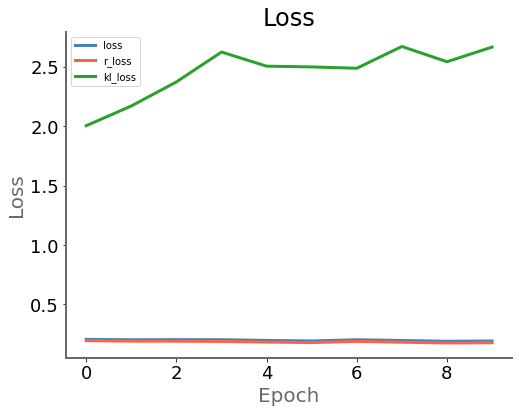

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

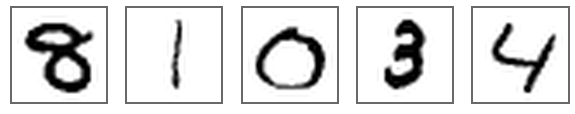

<br>**Encoded/decoded images**

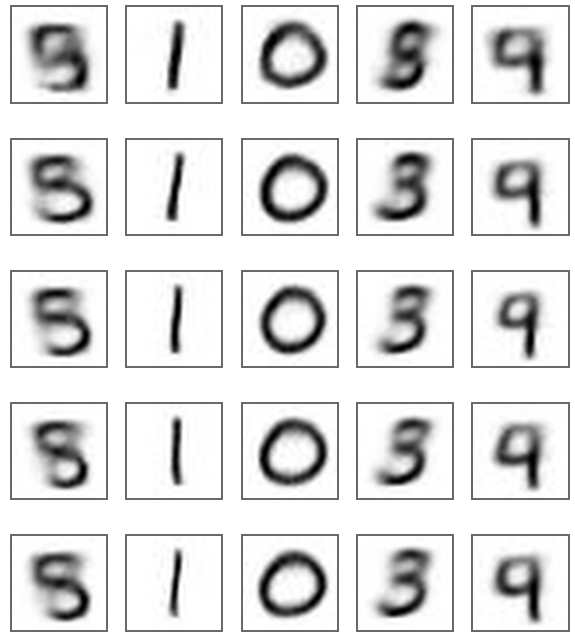

<br>**Original images :**

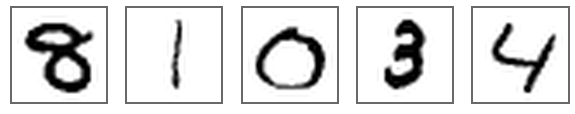

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

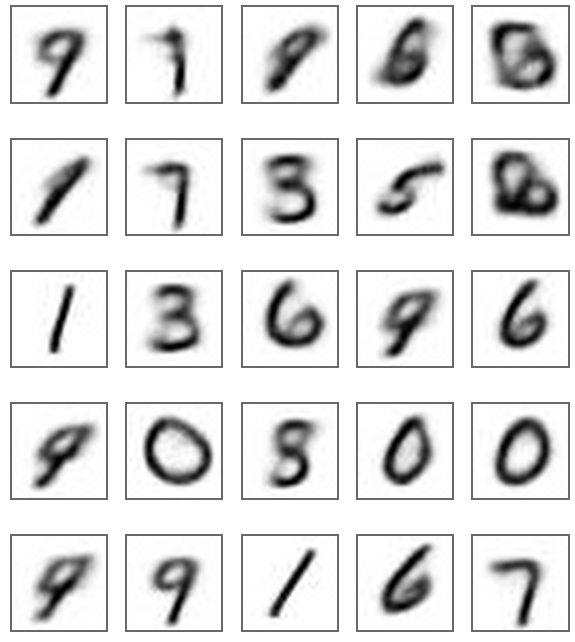

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Monday 01 March 2021, 20:36:25
Duration is : 00:01:14 468ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>